In [1]:
!nvidia-smi

Mon Jun 20 20:53:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Google Drive Connection

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path = '/content/drive/MyDrive/data/face-recognition'

# Utilities

In [4]:
def sliding_window(image, batch):
    for y in range(0, image.shape[0], batch[0]):
        for x in range(0, image.shape[1], batch[1]):
            yield x, y, image[y:y + batch[1], x:x + batch[0]]

In [5]:
import numpy as np
from skimage import feature

def find_lbp_histogram(image, n_batch=(8, 8)):
    features = []
    batch_size = (
        int(np.floor(image.shape[0] / n_batch[0])),
        int(np.floor(image.shape[1] / n_batch[1]))
    )

    lbp_img = feature.local_binary_pattern(image, P=8, R=1, method="default")

    for (x, y, C) in sliding_window(lbp_img, batch_size):
        if C.shape[0] != batch_size[0] or C.shape[1] != batch_size[1]:
            continue

        H = np.histogram(C, bins=64, density=True)[0]
        H = H.astype("float")
        H /= H.sum()

        features.extend(H)

    return features

In [6]:
import cv2

def detect_faces(gray_image):
    faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_alt.xml")
    return faceCascade.detectMultiScale(
        gray_image,
        scaleFactor=1.2,
        minNeighbors=3
    )

# Database Cleaning

In [7]:
import os
import shutil

def preprocess_dataset(dataset_path, preprocessed_data_path) -> None:
    print('Starting the preprocessing...')

    shutil.rmtree(preprocessed_data_path)
    os.mkdir(preprocessed_data_path)
    for player_name in os.listdir(dataset_path):
        os.mkdir(os.path.join(preprocessed_data_path, player_name))

    n_images = 0
    omitted_images = 0

    for player_name in os.listdir(dataset_path):
        player_path = os.path.join(dataset_path, player_name)

        for image_name in os.listdir(player_path):
            print(player_name, image_name)

            image_path = os.path.join(player_path, image_name)

            image = cv2.imread(image_path)
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            faces = detect_faces(gray)

            if len(faces) == 1:
                x, y, w, h = faces[0]
                preprocessed_player_path = os.path.join(
                    preprocessed_data_path, player_name)

                cropped_face = gray[y:y + h, x:x + w]
                resized_image = cv2.resize(
                    cropped_face, (128, 128), interpolation=cv2.INTER_AREA)
                cv2.imwrite(os.path.join(preprocessed_player_path,
                            image_name), resized_image)
            else:
                os.remove(os.path.join(dataset_path, player_name, image_name))
                omitted_images += 1

            n_images += 1

    print("Total images in dataset: ", n_images)
    print("Omitted images: ", omitted_images)

    print('Preprocessing finished.')


Data Preprocessing

In [8]:
#already processed
#preprocess_dataset(path+'/dataset/football_golden_foot', path+'/dataset/preprocessed')

# Training

In [9]:
import pickle
import random

from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split


def train(train_dir):
    print('Training started')

    X = []
    y = []

    print('Extracting features...')
    for class_dir in os.listdir(train_dir):
        for img_path in os.listdir(os.path.join(train_dir, class_dir)):
            image = cv2.imread(os.path.join(train_dir, class_dir, img_path), cv2.IMREAD_GRAYSCALE)

            X.append(find_lbp_histogram(image))
            y.append(class_dir)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random.seed())
    svm_clf = SVC(C=100.0, probability=True)

    print('Fitting the model...')
    svm_clf.fit(X_train, y_train)

    print('Validating the model...')
    y_predict = svm_clf.predict(X_test)
    print(classification_report(y_test, y_predict))

    with open(path+'/model/Face_Recognition_LBPH_SVM.clf', 'wb') as f:
        pickle.dump(svm_clf, f)

    print('Model saved.')

Training

In [10]:
train(path+'/dataset/preprocessed')

Training started
Extracting features...
Fitting the model...
Validating the model...
                      precision    recall  f1-score   support

alessandro_del_piero       0.63      0.67      0.65        39
     andreas_iniesta       0.69      0.84      0.76        32
   andriy_shevchenko       0.68      0.78      0.73        41
   cristiano_ronaldo       0.65      0.77      0.70        43
       didier_drogba       0.74      0.85      0.79        20
      diego_maradona       0.90      0.90      0.90        30
      edinson_cavani       0.75      0.77      0.76        35
     francesco_totti       0.77      0.86      0.81        28
     gianlugi_buffon       0.70      0.63      0.67        30
       iker_casillas       0.77      0.79      0.78        29
        lionel_messi       0.78      0.76      0.77        41
         luka_modric       0.83      0.75      0.79        40
       mohamed_salah       0.86      0.81      0.83        31
        pavel_nedved       1.00      0.74     

# Prediction

In [18]:
def predict(image, model_path, threshold=None):
    with open(model_path, 'rb') as f:
        svm_clf = pickle.load(f)

    threshold = 0.3

    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    face_locations = detect_faces(image)

    if len(face_locations) == 0:
        return []

    faces_encodings = []
    for (x, y, w, h) in face_locations:
        cropped_face = image[y:y + h, x:x + w]
        resized_image = cv2.resize(
            cropped_face, (128, 128), interpolation=cv2.INTER_AREA)

        faces_encodings.append(find_lbp_histogram(resized_image))

    faces = []
    predictions = svm_clf.predict_proba(faces_encodings)
    for i in range(len(face_locations)):
        max_pred = np.argmax(predictions[i])
        if predictions[i][max_pred] > threshold:
            faces.append([svm_clf.classes_[max_pred], face_locations[i]])
        else:
            faces.append(['Unknown', face_locations[i]])

    return faces

In [19]:
from google.colab.patches import cv2_imshow

def draw_in_image(image_path):
    image = cv2.imread(image_path)
    prediction = predict(image, path+'/model/Face_Recognition_LBPH_SVM.clf')
    thickness = round(-0.9601 + 0.0031 * image.shape[0] + 0.0008 * image.shape[1])
    for i in range(len(prediction)):
        x, y, w, h = prediction[i][1]
        image = cv2.rectangle(image, (x, y), (x + w, y + h), (255, 255, 255), thickness)
        cv2.putText(image, prediction[i][0], (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, thickness / 2.3 + 0.3, (255, 255, 255), round(thickness * 1.3))

    return image

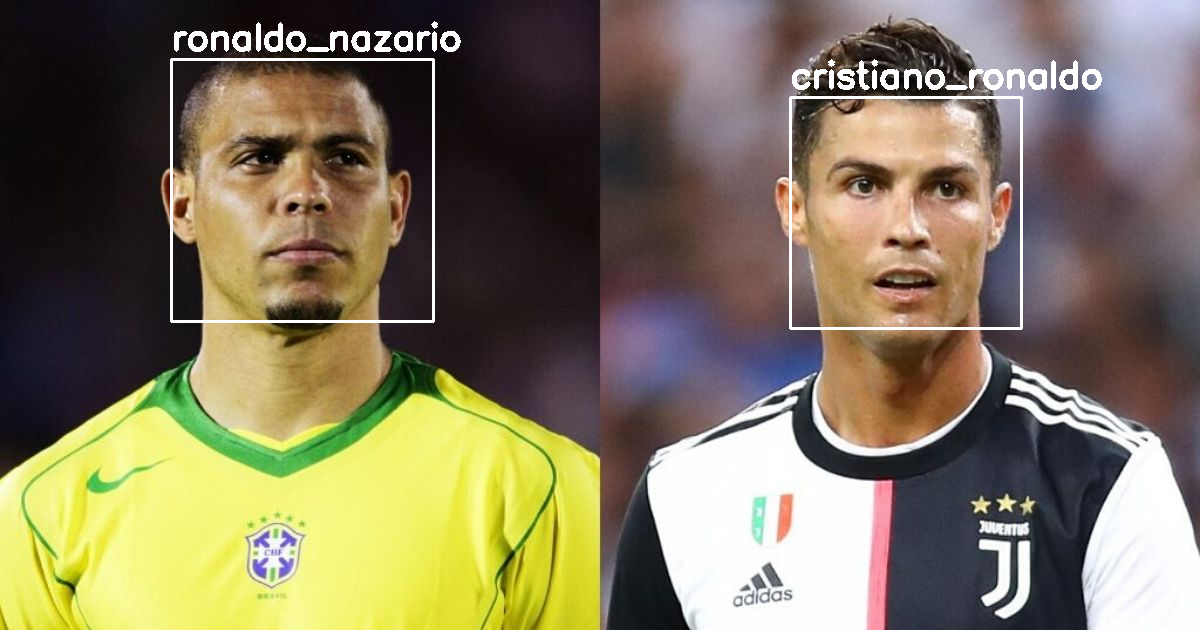

In [25]:
edited_img = draw_in_image(path+'/dataset/validation/15.jpg')
cv2_imshow(edited_img)